# Analyzing Bias in Detox Dataset

## Step 1: Download datasets

In [1]:
import urllib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.path.isdir('data')==False:
    os.mkdir('data')
if os.path.isdir('images')==False:
    os.mkdir('images')

In [3]:
def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

In [4]:
TOXICITY_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7394542' 
TOXICITY_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394539'
TOXICITY_WORKER_DEMOGRAPHICS_IRL = 'https://ndownloader.figshare.com/files/7640581'

download_file(TOXICITY_ANNOTATED_COMMENTS_URL, 'data/toxicity_annotated_comments.tsv')
download_file(TOXICITY_ANNOTATIONS_URL, 'data/toxicity_annotations.tsv')
download_file(TOXICITY_WORKER_DEMOGRAPHICS_IRL, 'data/toxicity_worker_demographics.tsv')

In [5]:
ATTACK_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ATTACK_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637'
ATTACK_WORKER_DEMOGRAPHICS_IRL = 'https://ndownloader.figshare.com/files/7640752'

download_file(ATTACK_ANNOTATED_COMMENTS_URL, 'data/attack_annotated_comments.tsv')
download_file(ATTACK_ANNOTATIONS_URL, 'data/attack_annotations.tsv')
download_file(ATTACK_WORKER_DEMOGRAPHICS_IRL, 'data/attack_worker_demographics.tsv')

## Step 2: Load tables using pandas

In [6]:
toxicity_annotations = pd.read_csv("data/toxicity_annotations.tsv", delimiter="\t")
toxicity_annotated_comments = pd.read_csv("data/toxicity_annotated_comments.tsv", delimiter="\t")
toxicity_worker_demographics = pd.read_csv("data/toxicity_worker_demographics.tsv", delimiter="\t")

toxicity_worker_demographics = toxicity_worker_demographics.set_index("worker_id")

In [7]:
attack_annotations = pd.read_csv("data/attack_annotations.tsv", delimiter="\t")
attack_annotated_comments = pd.read_csv("data/attack_annotated_comments.tsv", delimiter="\t")
attack_worker_demographics = pd.read_csv("data/attack_worker_demographics.tsv", delimiter="\t")

attack_worker_demographics = attack_worker_demographics.set_index("worker_id")

In [8]:
toxicity_annotations = pd.read_csv("data/toxicity_annotations.tsv", delimiter="\t")
toxicity_annotated_comments = pd.read_csv("data/toxicity_annotated_comments.tsv", delimiter="\t")
toxicity_worker_demographics = pd.read_csv("data/toxicity_worker_demographics.tsv", delimiter="\t")

toxicity_worker_demographics = toxicity_worker_demographics.set_index("worker_id")

# Analysis Questions

## Question 1: Analyze the level of disagreement among crowdworkers around certain labels

#### How much do labelers tend to agree while labelling hostile speech? Do people disagree more to a comment more likely to be labeled as hostile? Are some kinds of hostile speech harder for people to agree on than others? For example, do labelers tend to disagree more about “personal attacks” vs. “toxicity”?    

For this analysis, we use "entropy" to measure the level of disagreement between different workers on the labeling of each comment. Entropy is a measure of randomness in the data which makes it harder to draw any conclusions from. There are several ways to measure entropy. In this analysis, we use [Shannon's entropy](https://arxiv.org/ftp/arxiv/papers/1405/1405.2061.pdf#:~:text=Meaning%20of%20Entropy,of%20information%20in%20that%20variable)  which returns a value between 0 to 1. 0 indicates no entropy i.e. complete agreement while 1 indicates maximum disagreement i.e. 50-50 split between labels.

##### Step 1: We first compute the entropy in the toxicity and personal attacks annotations respectively.  

We also find the majority vote (is_toxic/is_attack) for each comment (e.g. is_toxic = 1 if more than half workers label the comment as toxic)

### Toxicity

In [9]:
toxicity_mean = toxicity_annotations.groupby("rev_id")["toxicity_score"].mean().to_frame().head().reset_index()

In [10]:
toxic_count = pd.DataFrame({"toxic_count": toxicity_annotations.groupby("rev_id")["toxicity"].apply(lambda c : c.sum())}).reset_index()

In [11]:
nontoxic_count = pd.DataFrame({"nontoxic_count": toxicity_annotations.groupby("rev_id")["toxicity"].apply(lambda c : (c == 0).sum())}).reset_index()

In [12]:
joined_toxicity_count = toxic_count.set_index("rev_id").join(nontoxic_count.set_index("rev_id")).reset_index()
joined_toxicity_count['total_count'] = joined_toxicity_count["toxic_count"] + joined_toxicity_count["nontoxic_count"]
joined_toxicity_count['p_toxic'] = joined_toxicity_count['toxic_count']/joined_toxicity_count['total_count']
joined_toxicity_count['p_nontoxic'] = joined_toxicity_count['nontoxic_count']/joined_toxicity_count['total_count']
joined_toxicity_count["entropy"] = -(np.log2(joined_toxicity_count['p_toxic'])*joined_toxicity_count['p_toxic']) - (np.log2(joined_toxicity_count['p_nontoxic'])*joined_toxicity_count['p_nontoxic'])
joined_toxicity_count["entropy"] = joined_toxicity_count["entropy"].fillna(0)
joined_toxicity_count['is_toxic'] = joined_toxicity_count['toxic_count']> joined_toxicity_count['nontoxic_count']

In [13]:
joined_toxicity_count.head()

,rev_id,toxic_count,nontoxic_count,total_count,p_toxic,p_nontoxic,entropy,is_toxic
0,2232.0,1,9,10,0.1,0.9,0.468996,False
1,4216.0,0,10,10,0.0,1.0,0.000000,False
2,8953.0,0,10,10,0.0,1.0,0.000000,False
3,26547.0,0,10,10,0.0,1.0,0.000000,False
4,28959.0,2,8,10,0.2,0.8,0.721928,False


### Personal Attacks

In [14]:
attack_count = pd.DataFrame({"attack_count": attack_annotations.groupby("rev_id")["attack"].apply(lambda c : c.sum())}).reset_index()

In [15]:
nonattack_count = pd.DataFrame({"nonattack_count": attack_annotations.groupby("rev_id")["attack"].apply(lambda c : (c == 0).sum())}).reset_index()

In [16]:
joined_attack_count = attack_count.set_index("rev_id").join(nonattack_count.set_index("rev_id")).reset_index()
joined_attack_count['total_count'] = joined_attack_count["attack_count"] + joined_attack_count["nonattack_count"]
joined_attack_count['p_attack'] = joined_attack_count['attack_count']/joined_attack_count['total_count']
joined_attack_count['p_nonattack'] = joined_attack_count['nonattack_count']/joined_attack_count['total_count']
joined_attack_count["entropy"] = -(np.log2(joined_attack_count['p_attack'])*joined_attack_count['p_attack']) - (np.log2(joined_attack_count['p_nonattack'])*joined_attack_count['p_nonattack'])
joined_attack_count["entropy"] = joined_attack_count["entropy"].fillna(0)
joined_attack_count['is_attack'] = joined_attack_count['attack_count']> joined_attack_count['nonattack_count']

In [17]:
joined_attack_count.head()

,rev_id,attack_count,nonattack_count,total_count,p_attack,p_nonattack,entropy,is_attack
0,37675,0.0,10,10.0,0.000000,1.000000,0.000000,False
1,44816,0.0,9,9.0,0.000000,1.000000,0.000000,False
2,49851,0.0,10,10.0,0.000000,1.000000,0.000000,False
3,89320,4.0,5,9.0,0.444444,0.555556,0.991076,False
4,93890,0.0,9,9.0,0.000000,1.000000,0.000000,False


###### Step 2: Next we compare the distribution of entropy (level of disagreement) between the comment labels for toxicity and personal attacks.

In [18]:
toxicity_vs_attack_entropy = joined_attack_count[['rev_id', 'entropy']].merge(joined_toxicity_count[['rev_id', 'entropy']], on = 'rev_id')[['entropy_x', 'entropy_y']]
toxicity_vs_attack_entropy.columns = ['attack', 'toxicity']

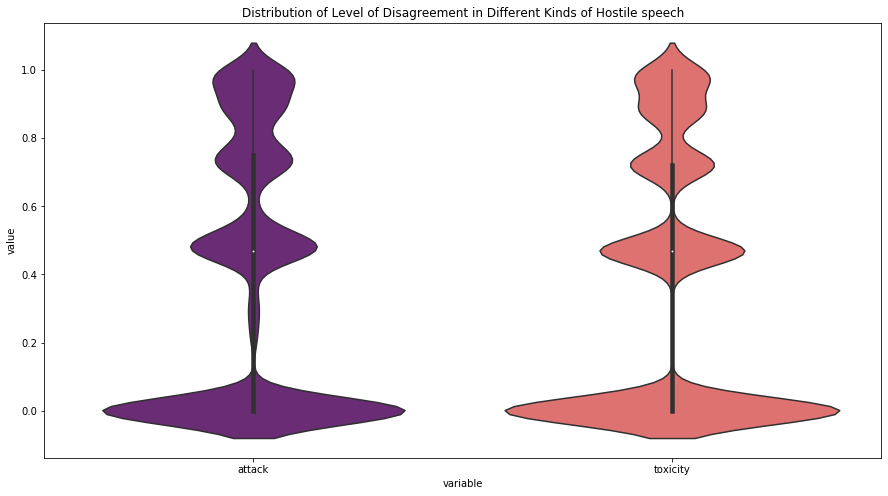

In [19]:
pd.melt(toxicity_vs_attack_entropy)
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of Level of Disagreement in Different Kinds of Hostile speech")
sns.violinplot( x="variable", y="value", data=pd.melt(toxicity_vs_attack_entropy), ax=ax, palette = 'magma' )
plt.savefig("images/label_disagreement_toxic_vs_attack.png")

We observe that both the distributions and means of the entropy for comments on toxicity and personal attacks are quite similar. This means that people tend to have a similar level of agreement while identifying different types of hostile speech.

###### Step 3: We compare the entropy between comments which were labelled as hostile by a majority of the labellers vs comments that were labelled as not hostile

We first compare the number of hostile to non-hostile comments. We observe that in both datasets (toxicity and personal attacks), there is higher number of comments that are marked as hostile.

In [20]:
joined_toxicity_count.groupby(['is_toxic'])['rev_id'].count().reset_index()

,is_toxic,rev_id
0,False,144324
1,True,15362


In [21]:
joined_attack_count.groupby(['is_attack'])['rev_id'].count().reset_index()

,is_attack,rev_id
0,False,102274
1,True,13590


### Toxicity

In [22]:
joined_toxicity_count.groupby('is_toxic')['entropy'].mean().reset_index()

,is_toxic,entropy
0,False,0.241561
1,True,0.531676


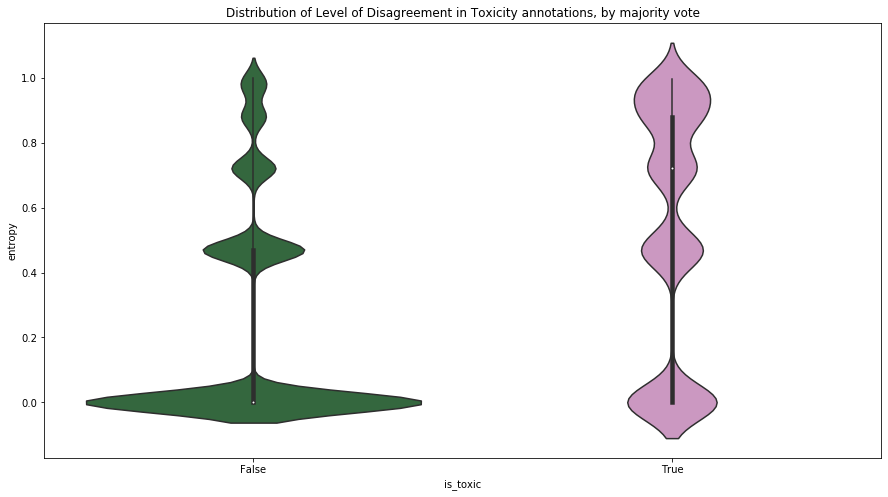

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of Level of Disagreement in Toxicity annotations, by majority vote")
sns.violinplot( x="is_toxic", y="entropy", data=joined_toxicity_count, ax=ax , palette = 'cubehelix')
plt.savefig("images/label_disagreement_toxicity.png")

We see that the mean entropy for comments labeled as not-toxic is lower (0.24) compared to the mean entropy when comments are labeled as toxic (0.53). This means that labelers tend to agree less that a comment is toxic although majority labelers do tend to label it as toxic.

### Personal Attacks

In [24]:
joined_attack_count.groupby('is_attack')['entropy'].mean().reset_index()

,is_attack,entropy
0,False,0.282741
1,True,0.587920


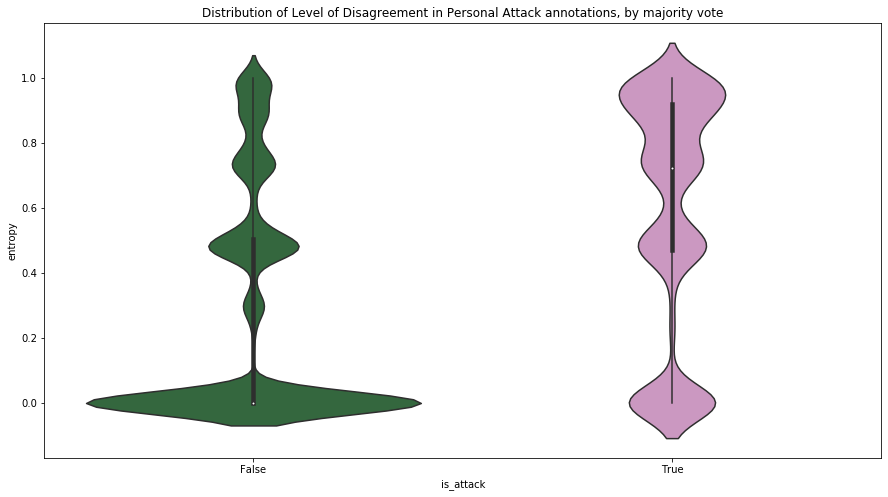

In [25]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of Level of Disagreement in Personal Attack annotations, by majority vote")
sns.violinplot( x="is_attack", y="entropy", data=joined_attack_count, ax=ax, palette = 'cubehelix' )
plt.savefig("images/label_disagreement_attack.png")

We see that similar to the toxicity data, the mean entropy for comments labeled as not-attacks is lower (0.28) compared to the mean entropy when comments are labeled as attacks (0.58). This means that labelers tend to agree less that a comment is an attack although majority labelers do tend to label it as attack.

### Results  

Labelers tend to agree and disagree similarly for the different kinds of hostile speech (toxicity and personal attack).  
A higher mean entropy indicates that there is more disagreement between the labelling of comments that are voted as having hostile speech by a majority of the annotators. This indicates that there is more ambiguity between the decision to label comments as toxic/attack. Thus any model trained on this data might not do a very good job in detecting comments with toxicity or personal attacks.

## Question 2: Explore relationships between worker demographics and labeling behavior

#### How consistent are labelling behaviors among workers with different demographic profiles? For example, are female-identified labelers more or less likely to label comments as aggressive than male-identified labelers?

For this analysis, we compare the proportion of comments that are marked as toxic between different groups in demographic profiles such as gender, age, education and language. If the data is unbiased we should observe similar proportions between the groups.

##### Step 1: Join the annotation data with the worker demographics data

In [26]:
toxicity_worker_demographics = toxicity_worker_demographics.reset_index()
attack_worker_demographics = attack_worker_demographics.reset_index()

In [27]:
toxicity_label_demographics = toxicity_annotations.set_index('worker_id').join(toxicity_worker_demographics.set_index('worker_id'))

In [28]:
toxicity_label_demographics.head()

,rev_id,toxicity,toxicity_score,gender,english_first_language,age_group,education
worker_id,,,,,,,
0,227181.0,0,0.0,male,0.0,30-45,professional
0,1557225.0,0,0.0,male,0.0,30-45,professional
0,1985687.0,0,0.0,male,0.0,30-45,professional
0,8612804.0,0,0.0,male,0.0,30-45,professional
0,11959295.0,0,0.0,male,0.0,30-45,professional


In [29]:
attack_label_demographics = attack_annotations.set_index('worker_id').join(attack_worker_demographics.set_index('worker_id'))

In [30]:
attack_label_demographics.head()

,rev_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack,gender,english_first_language,age_group,education
worker_id,,,,,,,,,,
0,537948,0.0,0.0,0.0,0.0,0.0,male,0.0,18-30,hs
0,5158305,0.0,0.0,0.0,0.0,0.0,male,0.0,18-30,hs
0,5646320,0.0,0.0,0.0,0.0,0.0,male,0.0,18-30,hs
0,10082841,0.0,0.0,0.0,0.0,0.0,male,0.0,18-30,hs
0,10283381,0.0,0.0,0.0,0.0,0.0,male,0.0,18-30,hs


##### Step 2: Find proportion of comments marked as hostile for different demographic profile groups

### Gender

In [31]:
toxicity_gender_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('gender')['rev_id'].count().reset_index()
toxicity_gender_totals = toxicity_label_demographics.groupby('gender')['rev_id'].count().reset_index()
toxicity_gender_labels['proportion'] = toxicity_gender_labels['rev_id']/toxicity_gender_totals['rev_id']

In [32]:
toxicity_gender_labels.head()

,gender,rev_id,proportion
0,female,71846,0.157093
1,male,124394,0.139886
2,other,59,0.164804


In [33]:
attack_gender_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('gender')['rev_id'].count().reset_index()
attack_gender_totals = attack_label_demographics.groupby('gender')['rev_id'].count().reset_index()
attack_gender_labels['proportion'] = attack_gender_labels['rev_id']/attack_gender_totals['rev_id']

In [34]:
attack_gender_labels

,gender,rev_id,proportion
0,female,53486,0.173598
1,male,86856,0.158691
2,other,37,0.445783


In [35]:
toxicity_vs_attack_gender = toxicity_gender_labels.merge(attack_gender_labels, on = 'gender')
toxicity_vs_attack_gender = pd.DataFrame({'gender': toxicity_vs_attack_gender['gender'], 'toxicity':  toxicity_vs_attack_gender['proportion_x'], 'attack': toxicity_vs_attack_gender['proportion_y']})
toxicity_vs_attack_gender = toxicity_vs_attack_gender.set_index('gender').stack().reset_index()

In [36]:
toxicity_vs_attack_gender.columns = ['gender', 'type', 'comments_proportion']

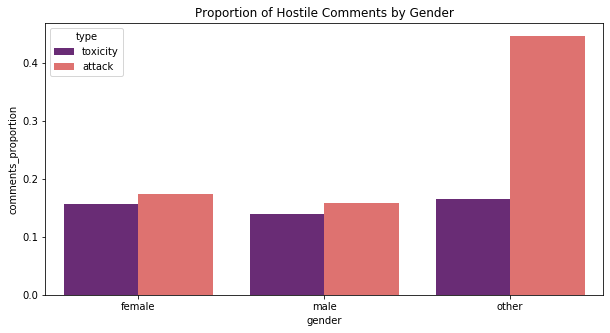

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Proportion of Hostile Comments by Gender")
sns.barplot(x = 'gender', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_gender)
plt.savefig("images/hostile_comments_by_gender.png")

### Age Group

In [38]:
toxicity_age_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('age_group')['rev_id'].count().reset_index()
toxicity_age_totals = toxicity_label_demographics.groupby('age_group')['rev_id'].count().reset_index()
toxicity_age_labels['proportion'] = toxicity_age_labels['rev_id']/toxicity_age_totals['rev_id']

In [39]:
toxicity_age_labels

,age_group,rev_id,proportion
0,18-30,99976,0.141173
1,30-45,69997,0.149421
2,45-60,17145,0.166251
3,Over 60,1525,0.156941
4,Under 18,3383,0.120135


In [40]:
attack_age_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('age_group')['rev_id'].count().reset_index()
attack_age_totals = attack_label_demographics.groupby('age_group')['rev_id'].count().reset_index()
attack_age_labels['proportion'] = attack_age_labels['rev_id']/attack_age_totals['rev_id']

In [41]:
attack_age_labels

,age_group,rev_id,proportion
0,18-30,59083,0.151033
1,30-45,60842,0.170147
2,45-60,16118,0.208477
3,Over 60,1496,0.190792
4,Under 18,1081,0.112875


In [42]:
toxicity_vs_attack_age = toxicity_age_labels.merge(attack_age_labels, on = 'age_group')
toxicity_vs_attack_age = pd.DataFrame({'age_group': toxicity_vs_attack_age['age_group'], 'toxicity':  toxicity_vs_attack_age['proportion_x'], 'attack': toxicity_vs_attack_age['proportion_y']})
toxicity_vs_attack_age = toxicity_vs_attack_age.set_index('age_group').stack().reset_index()

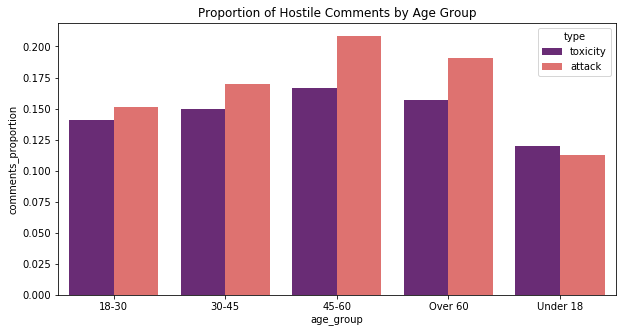

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Proportion of Hostile Comments by Age Group")
toxicity_vs_attack_age.columns = ['age_group', 'type', 'comments_proportion']
sns.barplot(x = 'age_group', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_age)
plt.savefig("images/hostile_comments_by_age.png")

### Education

In [44]:
toxicity_education_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('education')['rev_id'].count().reset_index()
toxicity_education_totals = toxicity_label_demographics.groupby('education')['rev_id'].count().reset_index()
toxicity_education_labels['proportion'] = toxicity_education_labels['rev_id']/toxicity_education_totals['rev_id']

In [45]:
toxicity_education_labels

,education,rev_id,proportion
0,bachelors,80718,0.149419
1,doctorate,1908,0.130837
2,hs,54382,0.142544
3,masters,30281,0.147407
4,none,122,0.131892
5,professional,24106,0.143100
6,some,4782,0.133419


In [46]:
attack_education_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('education')['rev_id'].count().reset_index()
attack_education_totals = attack_label_demographics.groupby('education')['rev_id'].count().reset_index()
attack_education_labels['proportion'] = attack_education_labels['rev_id']/attack_education_totals['rev_id']

In [47]:
attack_education_labels

,education,rev_id,proportion
0,bachelors,57262,0.165394
1,doctorate,1250,0.164193
2,hs,38406,0.161181
3,masters,25213,0.165614
4,none,6,0.063158
5,professional,15666,0.167827
6,some,2576,0.145331


In [48]:
toxicity_vs_attack_education = toxicity_education_labels.merge(attack_education_labels, on = 'education')
toxicity_vs_attack_education = pd.DataFrame({'education': toxicity_vs_attack_education['education'], 'toxicity':  toxicity_vs_attack_education['proportion_x'], 'attack': toxicity_vs_attack_education['proportion_y']})
toxicity_vs_attack_education = toxicity_vs_attack_education.set_index('education').stack().reset_index()

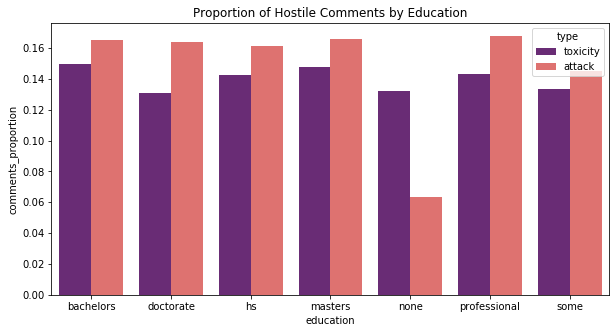

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Proportion of Hostile Comments by Education")
toxicity_vs_attack_education.columns = ['education', 'type', 'comments_proportion']
sns.barplot(x = 'education', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_education)
plt.savefig("images/hostile_comments_by_education.png")

### First language

In [50]:
toxicity_language_labels = toxicity_label_demographics[toxicity_label_demographics['toxicity'] == 1].groupby('english_first_language')['rev_id'].count().reset_index()
toxicity_language_totals = toxicity_label_demographics.groupby('english_first_language')['rev_id'].count().reset_index()
toxicity_language_labels['proportion'] = toxicity_language_labels['rev_id']/toxicity_language_totals['rev_id']

In [51]:
toxicity_language_labels

,english_first_language,rev_id,proportion
0,0.0,160714,0.144376
1,1.0,35585,0.152207


In [52]:
attack_language_labels = attack_label_demographics[attack_label_demographics['attack'] == 1].groupby('english_first_language')['rev_id'].count().reset_index()
attack_language_totals = attack_label_demographics.groupby('english_first_language')['rev_id'].count().reset_index()
attack_language_labels['proportion'] = attack_language_labels['rev_id']/attack_language_totals['rev_id']

In [53]:
attack_language_labels

,english_first_language,rev_id,proportion
0,0.0,119736,0.161422
1,1.0,20643,0.181469


In [54]:
toxicity_vs_attack_language = toxicity_language_labels.merge(attack_language_labels, on = 'english_first_language')
toxicity_vs_attack_language = pd.DataFrame({'english_first_language': toxicity_vs_attack_language['english_first_language'], 'toxicity':  toxicity_vs_attack_language['proportion_x'], 'attack': toxicity_vs_attack_language['proportion_y']})
toxicity_vs_attack_language = toxicity_vs_attack_language.set_index('english_first_language').stack().reset_index()

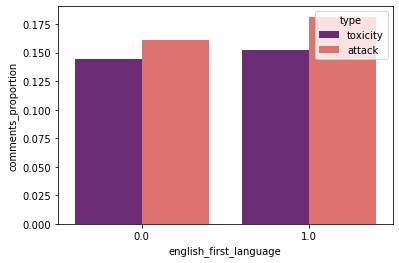

In [55]:
toxicity_vs_attack_language.columns = ['english_first_language', 'type', 'comments_proportion']
sns.barplot(x = 'english_first_language', y = 'comments_proportion', hue = 'type', palette = 'magma', data = toxicity_vs_attack_language)

### Results  

We observe that there is a similar proportions being tagged as toxic or attack among the different age groups and first language. We see that while the proportion of comments marked as toxic remains similar between different genders, there is an increase in the proportion of comments that workers of 'other' gender label as containing attacks. The possible reason for this could be that the comments annotated for attacks may contain words pertaining to gender or hostile comments for non-binary people.  
We also see that workers with no educational background labelled fewer comments as containing personal attacks.

# Further Implications

**Q1: Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?**  
The [WikiDetox](https://github.com/conversationai/wikidetox) project would perform well as the data collected for training matches the type of data that is to be tested for personal attacks and toxicity. Since there is no bias in the two collection strategies the model would work well unless an external bias is present in the test data.  
[Author Perspective for Drupal](https://www.drupal.org/project/perspective) filters the hostile comments causing harassment. This is a perfect usecase for Perspective API—or any model trained on the Wikipedia Talk corpus  

**Q2:Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?**  
The [Comment Filter](https://github.com/conversationai/perspective-hacks/blob/master/comment_filter/README.md) project may not work that well as the data to be tested is based on the articles from different sites. Since the data sources are different and may have a different context, the model may not perform as well. The training data would then be biased for the Wikipedia Talk Corpus.  
Similarly the Authorship Feedback tool may not perform well since the data is free-form input text (may contain a lot of spelling and grammatical errors) and may be very different from the Wikipedia Talk Corpus.

**Q3:What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models?**  
Models trained on the Wikipedia Talk corpus are language biased. Since the data is English only, any models would find it difficult to accurately detect hostile speeches in non-English languages. Any comments with sarcasm also has high chances of being inaccurately labeled. 